This notebook evaluates performance gains of `CudaCosineGreedy` against `matchms`.

Performance depends heavily on used hardware, as well as how correlated the spectra are with each other, (i.e. on average, how many common pairs of peaks do spectra have). 

This specific notebook evaluates the performance given the following below arguments (feel free to change these):

In [1]:
# We can use pickled version for much faster loading times
spectra_file = 'GNPS-LIBRARY-default-filter-nmax-2048.pickle'

# We take a random sample of spectra from said file

# Minimum size:
chunk_sizes_min = 32

# Maximum size
chunk_sizes_max = 14_000

# how many points to evaluate (in logspace) between min and max
num_evals = 15

# max number of peaks to retain in any spectra - larger numbers are marginally more accurate, but much slower
n_max_peaks = 1024

# Match limit
match_limit = 2048

# tolerance
tolerance = 0.1

# optimal batch size is hardware-dependent, but usually the best number is the largest the hardware can handle (without an OOM error)
batch_size = 4096

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA A100 80GB PCIe (UUID: GPU-5c695d34-741f-6e97-b8c6-1d4ceed5c634)
Number of CPU cores 24


In [2]:
from cudams.utils import argbatch, Timer
from cudams.similarity.spectrum_similarity_functions import cosine_greedy_kernel
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
from cudams.utils import download
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf
from cudams.utils import mute_stdout

spectra = pickle.load(open(download(spectra_file),'rb'))
assert cuda.is_available()

/opt/conda/lib/python3.10/site-packages/sparsestack/StackedSparseArray.py:4: DeprecationWarning: Please use `get_index_dtype` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import get_index_dtype


In [4]:
from cudams.similarity import CudaCosineGreedy

np.random.seed(42)
chunk_sizes_cu = np.round(np.logspace(
    np.log2(chunk_sizes_min), 
    np.log2(chunk_sizes_max), 
    num=num_evals, 
    base=2, 
    endpoint=True)
).astype(int)

times_cu = []
pairs_cu = []

# Kernel compilation might take a bit of time initially
kernel = CudaCosineGreedy(batch_size=batch_size, 
                          n_max_peaks=n_max_peaks)

# To force CUDA to load code to GPU, we need to do warmup
kernel.matrix(spectra[:64], spectra[:64])

# We avoid parallel here, since we only have one GPU, after all.
for chunk_size in tqdm(chunk_sizes_cu):
    chunk_size = min(len(spectra), chunk_size) # We might run out of spectra
    references = spectra[:chunk_size]
    queries = references # Pairwise
    with Timer() as timer:
        kernel.matrix(references, queries)
    times_cu.append(timer.duration)
    pairs_cu.append(len(references) * len(queries)) # We've processed all pairs

100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


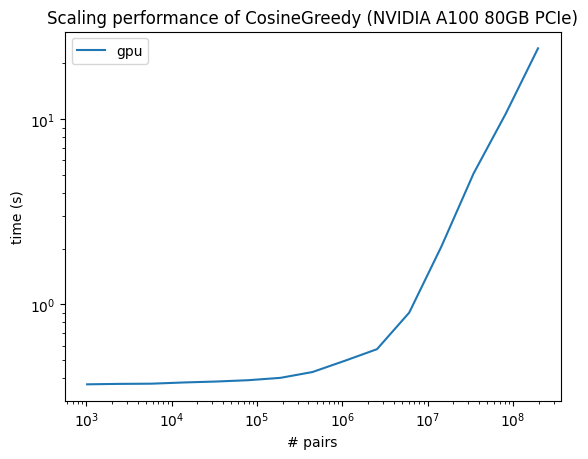

In [5]:
plt.loglog(pairs_cu, times_cu, label='gpu')
plt.title(f"Scaling performance of CosineGreedy ({torch.cuda.get_device_name()})")
plt.xlabel("# pairs")
plt.ylabel("time (s)")
plt.legend()
plt.show()

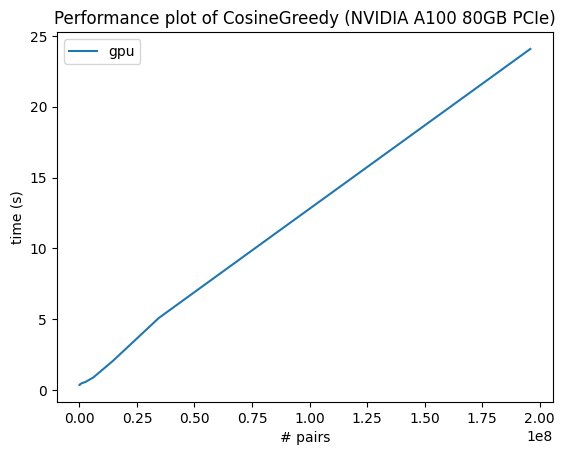

In [6]:
plt.plot(pairs_cu, times_cu, label='gpu')
plt.title(f"Performance plot of CosineGreedy ({torch.cuda.get_device_name()})")
plt.xlabel("# pairs")
plt.ylabel("time (s)")
plt.legend()
plt.show()

In [7]:
import json, os

benchmark_summary = dict(
        pairs_cu=pairs_cu,
        times_cu=times_cu,
        device=torch.cuda.get_device_name(),
        nproc=os.cpu_count(),    
    )
print(json.dumps(benchmark_summary,indent=1))

{
 "pairs_cu": [
  1024,
  2401,
  5776,
  13924,
  33124,
  78961,
  188356,
  447561,
  1067089,
  2547216,
  6071296,
  14470416,
  34492129,
  82210489,
  196000000
 ],
 "times_cu": [
  0.37108187400735915,
  0.3730855100147892,
  0.37402543300413527,
  0.37973768400843255,
  0.3841764400131069,
  0.3905353570007719,
  0.40211405997979455,
  0.4323857040144503,
  0.4969189339899458,
  0.5742074710142333,
  0.90392433598754,
  2.055448299011914,
  5.093195649998961,
  10.707494294998469,
  24.077000410004985
 ],
 "device": "NVIDIA A100 80GB PCIe",
 "nproc": 24
}
